# Quantum Gate Cloning

In [ ]:
# This example shows one-to-two cloning of unitary gate in one dimension. 

# Reference:
# Giulio Chiribella, Giacomo Mauro D’Ariano, and Paolo Perinotti, "Optimal cloning of unitary transformations"

In [1]:
# import
import numpy as np
import scipy.linalg as lin
import itertools
from math import pi
import matplotlib.pyplot as plt

# %matplotlib inline

from qiskit import (
    QuantumCircuit,
    Aer,
    transpile,
)
from qiskit.visualization import (
    plot_histogram,
    plot_bloch_multivector
)
from qiskit.quantum_info import (
    partial_trace,
)
from qiskit.circuit.library.standard_gates import UGate

print("Imports Successful")


Imports Successful


In [2]:
def calc_theta(p):
    if p >= 0:
        return 2 * np.arccos(np.sqrt(p))
    else:
        return -2 * np.arccos(np.sqrt(-p))


def calc_attenuate_theta(p0, p1):
    return calc_theta(p1/p0)


def fill_result(result):
    bit_len = len(list(result.keys())[0])
    bit = ["0", "1"]
    key_list = ["".join(bits)
                for bits in itertools.product(bit, repeat=bit_len)]

    total = sum(result.values())
    result_new = {}
    for k in key_list:
        v = result.get(k)
        result_new[k] = 0 if v is None else v / total
    return result_new


def count_result(result, filter_str):
    bit_list = []
    for bit_str in filter_str:
        if bit_str == "0" or bit_str == "1":
            bit_list.append([bit_str])
        else:
            bit_list.append(["0", "1"])
    key_list = ["".join(bits) for bits in itertools.product(*bit_list)]

    total = 0
    for k in key_list:
        total += result[k]

    return total


def round_mat(mat, delta):
    mat_real = mat.real
    mat_imag = mat.imag
    mat_real = np.where(np.logical_and(-delta < mat_real,
                        mat_real < delta), 0.0, mat_real)
    mat_imag = np.where(np.logical_and(-delta < mat_imag,
                        mat_imag < delta), 0.0, mat_imag)
    return mat_real + mat_imag * 1.0j


def fidelity(rho, sigma):
    rho_round = round_mat(rho, 0.00001)
    sigma_round = round_mat(sigma, 0.00001)
    rho_1_2, _ = lin.sqrtm(np.array(rho_round), False)
    sq_fidelity_mat = np.matmul(
        np.matmul(rho_1_2, np.array(sigma_round)), rho_1_2)
    fidelity_mat, _ = lin.sqrtm(sq_fidelity_mat, False)
    return np.trace(fidelity_mat)


In [3]:
def attenuate(qc, q0, q1, c0, p0, p1):
    # q0: target qubit
    # q1: qubit (ancilla)
    # c0: classical bit (ancilla)
    # p0: real coefficient
    # p1: real coefficient
    # if c0 = 0 then q0  = (sqrt(a1)|0> + sqrt(a2)|1>) / sqrt(a1 + a2)
    #             -> q0' = (sqrt(a1 * p0)|0> + sqrt(a2 * p1)|1>) / sqrt(a1 * p0 + a2 * p1)
    # if c0 = 1 then q0  -> q0' = |0>

    # sin(theta0 / 2)^2 = gamma = 1 - p1/p0
    theta0 = calc_attenuate_theta(p0, p1)
    # UGate(theta0, 0, q0) = exp(-i * theta0 * Y / 2)
    # = [ [cos(theta0 / 2), -sin(theta0 / 2)],
    #     [sin(theta0 / 2),  cos(theta0 / 2)] ]
    control_UGate = UGate(theta0, 0, q0).control(1)
    qc.append(control_UGate, [q0, q1])
    qc.cx(q1, q0)
    qc.measure(q1, c0)


def attenuate_2q(qc, q0, q1, q2, q3, c0, p0, p1):
    # q0: target qubit
    # q1: target qubit
    # q2: qubit (ancilla)
    # q3: qubit (ancilla)
    # c0: classical bit (ancilla)
    # p0: real coefficient
    # p1: real coefficient
    # unitary gate =
    #  [[p0,  0,  0,  0],
    #   [ 0, p0,  0,  0],
    #   [ 0,  0, p0,  0],
    #   [ 0,  0,  0, p1]], if c0 = 0
    if p0 < p1:
        qc.x(q2)
    qc.ccx(q0, q1, q2)
    if p0 < p1:
        attenuate(qc, q2, q3, c0, p1, p0)
    else:
        attenuate(qc, q2, q3, c0, p0, p1)
    qc.ccx(q0, q1, q2)
    if p0 < p1:
        qc.x(q2)


In [4]:
def qcA(qc, q0, q1, q2):
    # q0: input of U
    # q1: input of cloned U
    # q2: output of sigma (q2 must be initialized to |0>)
    qc.h(q2)
    qc.cswap(q2, q0, q1)


def qcB(qc, q0, q1, q2, q3, q4, c0, c1):
    # q0: output of U
    # q1: output of sigma
    # q2: output of cloned U (q2 must be initialized to |0>)
    # q3: qubit (ancilla)
    # q4: qubit (ancilla)
    # c0: classical bit (ancilla)
    # c1: classical bit (ancilla)

    qc.h(q2)
    qc.measure(q2, c0)
    qc.cswap(q1, q0, q2)

    qc.cx(q0, q2)
    qc.cx(q2, q0)
    control_UGate = UGate(-pi/2, 0, 0).control(1)
    qc.append(control_UGate, [q2, q0])
    attenuate_2q(qc, q0, q2, q3, q4, c1, 1/3.0, 1/1.0)
    control_UGate = UGate(0, 0, pi).control(1)
    qc.append(control_UGate, [q2, q0])
    control_UGate = UGate(pi/2, 0, pi).control(1)
    qc.append(control_UGate, [q2, q0])
    qc.cx(q2, q0)
    qc.cx(q0, q2)


def setup_state(qsetup, qc, q0, q1):
    if type(qsetup) == tuple:
        q0_setup = qsetup[0]
        qc.u(q0_setup[0], q0_setup[1], q0_setup[2], q0)
        q1_setup = qsetup[1]
        qc.u(q1_setup[0], q1_setup[1], q1_setup[2], q1)
    else:
        if qsetup == "|00>":
            pass
        elif qsetup == "|01>":
            qc.x(q0)
        elif qsetup == "|10>":
            qc.x(q1)
        elif qsetup == "|11>":
            qc.x(q0)
            qc.x(q1)
        else:
            raise Exception("Invalid qsetup {}".format(qsetup))


def setup_U(Usetup, qc, q0):
    if type(Usetup) == tuple:
        q0_setup = Usetup
        qc.u(q0_setup[0], q0_setup[1], q0_setup[2], q0)
    else:
        qc.x(q0)


def calc_qc_fidelity(qc_setup, sampleN):
    # calculate the fidelity of cloning
    def calc_density(sim_setup):
        sv_simulator = sim_setup[0]
        circuit = sim_setup[1]
        trace_reduced = sim_setup[2]
        trace_measure = sim_setup[3]
        statevector_sim = np.asarray(
            sv_simulator.run(circuit).result().data()['statevector'])
        if len(trace_measure) > 0:
            statedensity_measure = np.array(partial_trace(
                statevector_sim, trace_measure)).real
            # if 0.999 > statedensity_q5[0][0] or statedensity_q5[0][0] > 1.001:
            #    # if c1 (measurement result of q5) is 1, then skip
            #    return False, None
        return True, np.array(
            partial_trace(statevector_sim, trace_reduced))

    def calc_density_list(sim_setup, sampleN):
        count = 0.0
        count_success = 0.0
        density_list = []
        statedensity = None
        while True:
            if count >= sampleN:
                break
            if len(sim_setup[3]) > 0 or statedensity is None:
                flag, statedensity = calc_density(sim_setup)
            count += 1.0
            if not flag:
                continue
            count_success += 1.0
            density_list.append(statedensity)
        return density_list, count_success/count

    # make sim_setup_list
    sim_setup_list = []
    for qc, qc_qbits, qc_cbits in qc_setup:
        trace_reduced = list(set(list(range(qc.num_qubits))) - set(qc_qbits))
        trace_measure = list(set(list(range(qc.num_qubits))) - set(qc_cbits))
        sv_simulator = Aer.get_backend('statevector_simulator')
        sim_setup_list.append(
            (sv_simulator,
             transpile(qc, backend=sv_simulator),
             trace_reduced,
             trace_measure)
        )

    # calculate the average of fidelity
    density_list0, success_rate0 = calc_density_list(
        sim_setup_list[0], sampleN)
    density_list1, success_rate1 = calc_density_list(
        sim_setup_list[1], sampleN)
    avg_fidelity = 0.0
    for density0, density1 in zip(density_list0, density_list1):
        avg_fidelity += fidelity(density0, density1) / sampleN

    return avg_fidelity, success_rate0, success_rate1


def calc_qc_fidelity_list(qsetup_Usetup_list, qc_build_setup, sampleN):
    fidelity_list = []
    for qsetup, Usetup in qsetup_Usetup_list:
        qc_setup = (
            (qc_build_setup[0][0](qsetup, Usetup), *qc_build_setup[0][1:3]),
            (qc_build_setup[1][0](qsetup, Usetup), *qc_build_setup[1][1:3]),
        )
        avg_fidelity, success_rate0, success_rate1 = calc_qc_fidelity(
            qc_setup, sampleN)
        fidelity_list.append(
            (qsetup, Usetup, avg_fidelity, success_rate0, success_rate1))
    return fidelity_list


def calc_global_fidelity(qc_build_setup):
    sampleN = 100
    num0 = 3  # 5
    num1 = 4  # 8
    U_theta_list = np.linspace(0, pi, num0, endpoint=True)
    U_phi_list = np.linspace(-pi, pi, num1, endpoint=False)
    U_lambda_list = np.linspace(-pi, pi, num1, endpoint=False)
    q1_theta_list = np.linspace(0, pi, num0, endpoint=True)
    q1_phi_list = np.linspace(-pi, pi, num1, endpoint=False)

    # make qsetup_Usetup_list
    q0_setup = (0, 0, 0)
    qsetup_Usetup_list = []
    for U_theta, U_phi, U_lambda, q1_theta, q1_phi in itertools.product(U_theta_list, U_phi_list, U_lambda_list, q1_theta_list, q1_phi_list):
        if q1_theta == 0 and q1_phi != -pi:
            continue
        if q1_theta == pi and q1_phi != -pi:
            continue
        q1_setup = (q1_theta, q1_phi, 0)
        Usetup = (U_theta, U_phi, U_lambda)
        qsetup_Usetup_list.append(((q0_setup, q1_setup), Usetup))

    # calculate the fidelity
    fidelity_result_list = calc_qc_fidelity_list(
        qsetup_Usetup_list, qc_build_setup, sampleN)

    # arrange the result into a list.
    sum_success_rate = 0.0
    fidelity_list = np.empty([0])
    for fidelity_result in fidelity_result_list:
        fidelity_list = np.append(fidelity_list, [fidelity_result[2].real])
        sum_success_rate += fidelity_result[4]

    # print("avg_success_rate = {}".format(sum_success_rate / len(fidelity_result_list)))
    print(f'number of points = {len(fidelity_result_list)}')
    return fidelity_list, fidelity_result_list


def plot_fidelity(qc_build_setup, q0_in_setup, q1_in_setup, Usetup_in):
    # q0 is set to cos(theta0/2)|0> + exp(i*phi0)*sin(theta0/2)|1>
    # q1 is set to cos(theta1/2)|0> + exp(i*phi1)*sin(theta1/2)|1>
    # U is set to UGate(theta3, phi3, lambda3)
    sampleN = 100
    theta3_list = np.linspace(-pi, pi, 10)
    sum_success_rate = 0

    # make qsetup_Usetup_list
    qsetup_Usetup_list = []
    for theta3 in theta3_list:
        q0_setup = q0_in_setup
        q1_setup = q1_in_setup
        Usetup = (theta3, Usetup_in[1], Usetup_in[2])
        qsetup_Usetup_list.append(((q0_setup, q1_setup), Usetup))

    # calculate the fidelity
    fidelity_list = calc_qc_fidelity_list(
        qsetup_Usetup_list, qc_build_setup, sampleN)

    # plot the fidelity
    sum_success_rate = 0.0
    y_list = np.empty([0, 2])
    for fidelity_info in fidelity_list:
        y_list = np.append(y_list, [fidelity_info[2].real])
        sum_success_rate += fidelity_info[4]
    plt.plot(theta3_list, y_list)
    plt.title("Fidelity\n(initial state q0 = ({:.2f}, {:.2f}, {:.2f}),\n q1 = ({:.2f}, {:.2f}, {:.2f})".format(
        *q0_rand_setup, *q1_rand_setup))
    plt.ylim([0, 1])
    plt.ylabel("Fidelity")
    plt.xlabel(
        f'theta of unitary gate UGate(theta, {Usetup[1]:.2f}, {Usetup[2]:.2f})')


# quantum circuit
def example_no_clone(qsetup, Usetup):
    # q0: input and output of U
    # q1: input and output of U
    qc = QuantumCircuit(2)
    setup_state(qsetup, qc, 0, 1)
    setup_U(Usetup, qc, 0)
    setup_U(Usetup, qc, 1)
    return qc


def example_clone(qsetup, Usetup):
    # q0: input and output of U
    # q1: input and output of cloned U
    # q2: output of sigma
    # q3: output of cloned U
    # q4: qubit (ancilla)
    # q5: qubit (ancilla)
    # c0: classical bit (ancilla)
    # c1: classical bit (ancilla)
    qc = QuantumCircuit(6, 2)

    setup_state(qsetup, qc, 0, 1)
    qc.barrier()
    qcA(qc, 0, 1, 2)
    qc.barrier()
    setup_U(Usetup, qc, 0)  # apply unitary gate U only to q0
    qc.barrier()
    qcB(qc, 0, 2, 3, 4, 5, 0, 1)

    return qc


def example_clone_dummy(qsetup, Usetup):
    # q0: input and output of U
    # q1: input and output of cloned U (dummy)
    qc = QuantumCircuit(2)
    setup_state(qsetup, qc, 0, 1)
    setup_U(Usetup, qc, 0)

    return qc


def example_clone_swap(qsetup, Usetup):
    # q0: input and output of U
    # q1: input and output of cloned U (dummy)
    qc = QuantumCircuit(3)
    setup_state(qsetup, qc, 0, 1)
    qc.h(2)
    qc.cswap(2, 0, 1)
    setup_U(Usetup, qc, 0)
    qc.cswap(2, 0, 1)
    qc.h(2)

    return qc


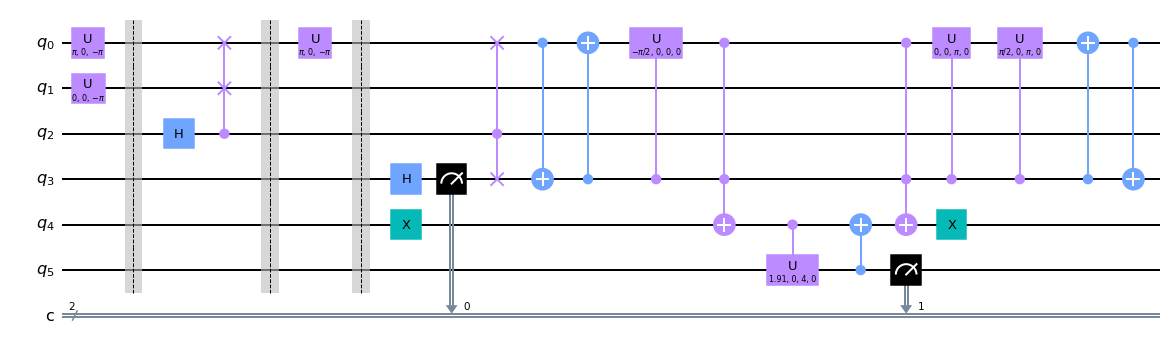

In [5]:
# optimal cloning
qc = example_clone(((pi, 0, -pi), (0, 0, -pi)), (pi, 0, -pi))
qc.draw(output="mpl")


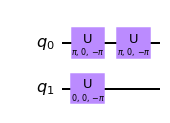

In [6]:
# dummy1
qc = example_clone_dummy(((pi, 0, -pi), (0, 0, -pi)), (pi, 0, -pi))
qc.draw(output="mpl")


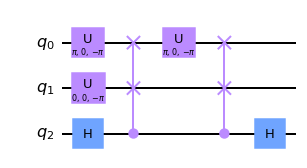

In [7]:
# dummy2
qc = example_clone_swap(((pi, 0, -pi), (0, 0, -pi)), (pi, 0, -pi))
qc.draw(output="mpl")


In [66]:
q0_rand_setup = (float(pi*np.random.rand(1)),
                 float(2*pi*np.random.rand(1)-pi), 0)
q1_rand_setup = (float(pi*np.random.rand(1)),
                 float(2*pi*np.random.rand(1)-pi), 0)
Usetup_rand = (float(pi*np.random.rand(1)), float(2*pi *
               np.random.rand(1)-pi), float(2*pi*np.random.rand(1)-pi))


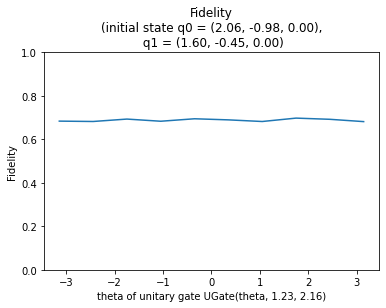

In [69]:
# example of q0 (= cos(theta0/2)|0> + exp(i*phi0)*sin(theta0/2)|1>)
# and q1 (= cos(theta1/2)|0> + exp(i*phi1)*sin(theta1/2)|1>) applied by one-to-two cloning of an unitary gate U.
# U is UGate(theta1, 0, -pi). the fidelity > 0.
# the result shows that one-to-two cloning makes an gate which approximates an unitary gate U x U from an unitary gate U.

# optimal cloning
plot_fidelity(
    (
        (example_no_clone, [0, 1], []),  # q0 (input of U), q1 (input of U)
        # q0 (input of U), q3 (input of cloned U), q5 (measure)
        (example_clone, [0, 3], [5]),
    ),
    q0_rand_setup,
    q1_rand_setup,
    Usetup_rand
)


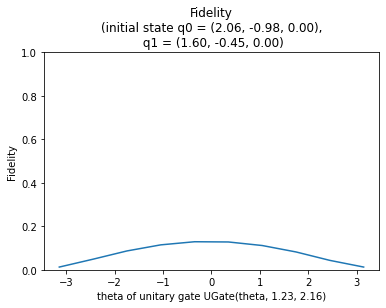

In [70]:
# dummy1
plot_fidelity(
    (
        (example_no_clone, [0, 1], []),  # q0 (input of U), q1 (input of U)
        # q0 (input of U), q1 (input of dummy)
        (example_clone_dummy, [0, 1], []),
    ),
    q0_rand_setup,
    q1_rand_setup,
    Usetup_rand
)


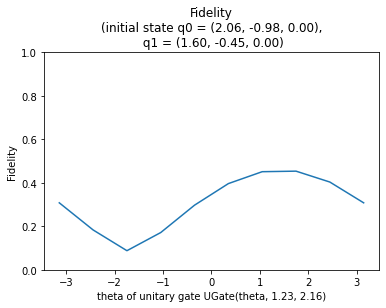

In [71]:
# dummy2
plot_fidelity(
    (
        (example_no_clone, [0, 1], []),  # q0 (input of U), q1 (input of U)
        # q0 (input of U), q1 (input of dummy)
        (example_clone_swap, [0, 1], []),
    ),
    q0_rand_setup,
    q1_rand_setup,
    Usetup_rand
)


In [73]:
# optimal cloning
# approximate value of the global fidelity > 0.
fidelity_list0, fidelity_result_list0 = calc_global_fidelity(
    (
        (example_no_clone, [0, 1], []),  # q0 (input of U), q1 (input of U)
        # q0 (input of U), q3 (input of cloned U), q5 (measure)
        (example_clone, [0, 3], [5]),
    )
)
print(f'fidelity = {np.min(fidelity_list0)}')


number of points = 288
fidelity = 0.4200000000000002


In [74]:
# dummy1
# approximate value of the global fidelity = 0.
fidelity_list1, fidelity_result_list1 = calc_global_fidelity(
    (
        (example_no_clone, [0, 1], []),  # q0 (input of U), q1 (input of U)
        # q0 (input of U), q1 (input of dummy)
        (example_clone_dummy, [0, 1], []),
    )
)
print(f'fidelity = {np.min(fidelity_list1)}')


number of points = 288
fidelity = 0.0


In [75]:
# dummy2
# approximate value of the global fidelity = 0.
fidelity_list2, fidelity_result_list2 = calc_global_fidelity(
    (
        (example_no_clone, [0, 1], []),  # q0 (input of U), q1 (input of U)
        # q0 (input of U), q1 (input of dummy)
        (example_clone_swap, [0, 1], []),
    )
)
print(f'fidelity = {np.min(fidelity_list2)}')


number of points = 288
fidelity = 0.0
